In [1]:
import numpy as np
def rmsle(predicted,real):    
    suma=0.0
    for x in range(len(predicted)):
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        suma += np.power((p - r),2)
    return np.sqrt(suma/len(predicted))


In [2]:
import matplotlib.pyplot as plt
def graficar_predicciones(real,predecido):
    plt.figure(figsize=(12,8))
    plt.plot(real,predecido,'b.')
    valor_max = int( np.max( [np.max(predecido),np.max(real)]))
    valor_min = int( np.min( [np.min(predecido),np.min(real)]))
    plt.plot(range(valor_min,valor_max+1), range(valor_min,valor_max+1), color ="r")
    plt.axis('tight')
    plt.xlabel('Valor Real')
    plt.ylabel('Prediccion')
    plt.show()

In [3]:
import pandas as pd
df1 = pd.read_csv("train.csv")
df1 = df1[(df1['trip_duration']<=10000)]
output = df1['trip_duration'].values

In [4]:
df1.head(1)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.96463,40.765602,N,455


In [5]:
from geopy.distance import great_circle
import numpy as np
"""extraer caract geograficas"""
def distance(p_lat,p_long,d_lat,d_long):
    pickup = (p_lat, p_long)
    dropoff = (d_lat, d_long)
    distance_all=great_circle(pickup, dropoff).km
    return distance_all
def grado(p_lat,p_long,d_lat,d_long):
    lat1= np.radians(p_lat)
    lat2= np.radians(d_lat)
    dLon = np.radians(d_long - p_long)
    y = np.sin(dLon)*np.cos(lat2)
    x = np.cos(lat1)*np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(dLon)
    return (np.degrees( np.arctan2(y,x) ) + 360 ) %360
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2015',end='2017')
def preprocesar_2(df1):
    df1.fillna(0,inplace=True)
    """transformar fechas a tiempos"""
    df1['hour'] = pd.to_datetime(df1['pickup_datetime']).dt.hour
    df1['hour'] = pd.to_numeric(df1['hour'])
    df1['cday'] = pd.to_datetime(df1['pickup_datetime']).dt.dayofweek #0:lunes,6:domingo
    df1['cday'] = pd.to_numeric(df1['cday'])
    df1['month'] = pd.to_datetime(df1['pickup_datetime']).dt.month #1:enero, 12: diciembre
    df1['month'] = pd.to_numeric(df1['month'])
    df1['year'] = pd.to_datetime(df1['pickup_datetime']).dt.year #1:enero, 12: diciembre
    df1['year'] = pd.to_numeric(df1['month'])
    
    """Feature Generation"""
    df1['distancia_viaje'] = np.sqrt( np.square(df1['pickup_longitude']-df1['dropoff_longitude']) 
                                    + np.square(df1['pickup_latitude']-df1['dropoff_latitude'])) #euclideana
    distancia_real_aprox = [ distance(df1['pickup_latitude'].values[i], 
                                 df1['pickup_longitude'].values[i],
                                 df1['dropoff_latitude'].values[i],
                                 df1['dropoff_longitude'].values[i]) for i in range(len(df1['pickup_latitude']))]
    df1['distancia_viaje_km'] = distancia_real_aprox
    df1['grado_direccion'] = [ grado(df1['pickup_latitude'].values[i],  #agregar direccion (en base a grado)
                                 df1['pickup_longitude'].values[i],
                                 df1['dropoff_latitude'].values[i],
                                 df1['dropoff_longitude'].values[i]) for i in range(len(df1['pickup_latitude']))]
    seasons = [0,0,1,1,1,2]  #0: winter, 1: spring, 2: summer
    df1['season'] = [ seasons[df1['month'].values[i] - 1] for i in range(len(df1['month'])) ]  #agregar temporada
    df1['holiday'] = df1['pickup_datetime'].isin(holidays) #holidays
    """ Eliminar columnas -- limpiar"""
    df1.drop(["pickup_datetime","dropoff_datetime","id","store_and_fwd_flag","vendor_id"], axis=1,inplace=True)
    df1["holiday"] = df1["holiday"].astype('category')#a categorico
    """codifica"""
    cat_columns = df1.select_dtypes(['category']).columns
    df1[cat_columns] = df1[cat_columns].apply(lambda x: x.cat.codes)
preprocesar_2(df1)
df1.head()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,hour,cday,month,year,distancia_viaje,distancia_viaje_km,grado_direccion,season,holiday
0,1,-73.982155,40.767937,-73.964630,40.765602,455,17,0,3,3,0.017680,1.498523,99.970196,1,0
1,1,-73.980415,40.738564,-73.999481,40.731152,663,0,6,6,6,0.020456,1.805510,242.846232,2,0
2,1,-73.979027,40.763939,-74.005333,40.710087,2124,11,1,1,1,0.059934,6.385108,200.319835,0,0
3,1,-74.010040,40.719971,-74.012268,40.706718,429,19,2,4,4,0.013438,1.485501,187.262300,1,0
4,1,-73.973053,40.793209,-73.972923,40.782520,435,13,5,3,3,0.010690,1.188590,179.473585,1,0


In [6]:
y = df1['trip_duration'].values
df1.drop("trip_duration",axis=1,inplace=True)
X = df1.values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
from sklearn.preprocessing import RobustScaler,StandardScaler
scaler = StandardScaler(with_mean=True, with_std=True)
scaler = RobustScaler(with_centering=True, with_scaling=True)
scaler.fit(X_train)


y_train=y_train[0:100000]
y_test = y_test[0:100000]
X_train_scaled = scaler.transform(X_train)
X_train_scaled = X_train_scaled[0:100000]
X_test_scaled = scaler.transform(X_test)
X_test_scaled = X_test_scaled[0:100000]


Resultado optimo con depth =  12
ERROR RMSLE de training:  0.40242737405081874
ERROR RMSLE de test:  0.44723285992039624
tiempo bloque 308.4857621192932


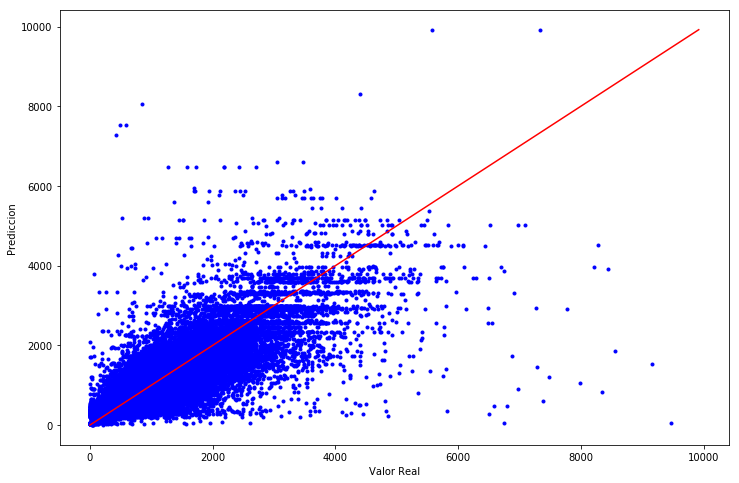

In [24]:
from sklearn.tree import DecisionTreeRegressor
import time
start = time.time()
error_min = 9999
error = 9999
depth = 1
for i in range(101):
    model =DecisionTreeRegressor(splitter = "best",max_depth=i+1)#SVM, Decision Trees or Neural Network
    model.fit(X_train_scaled,y_train)
   # rmsle(model.predict(X_train_scaled),y_train)
    error = rmsle(model.predict(X_test_scaled),y_test)
    if error<error_min:
        depth = i+1
        error_min = error

        
model =DecisionTreeRegressor(splitter = "best",max_depth=depth)#SVM, Decision Trees or Neural Network
model.fit(X_train_scaled,y_train)  
print("Resultado optimo con parametro max_depth = ",depth)
print ("ERROR RMSLE de training: ", rmsle(model.predict(X_train_scaled),y_train))
print ("ERROR RMSLE de test: ", rmsle(model.predict(X_test_scaled),y_test))        
        
end = time.time()
print("tiempo bloque", end-start)
graficar_predicciones(y_test,model.predict(X_test_scaled))

In [25]:

"""Separar viajes largos de viajes cortos"""
u = np.mean(X_train["distancia_viaje_km"])
mask = X_train["distancia_viaje_km"] <= u
X_train_1 = X_train[mask] #viaje cortos
y_train_1 = y_train[mask]
X_train_2 = X_train[~mask] #viaje largos
y_train_2 = y_train[~mask]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [8]:
df1.shape

(1456521, 14)

In [9]:

print(len(df1))

1456521
